In [2]:
import pandas as pd
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

from task_geo.data_sources.covid import cds
from task_geo.data_sources import get_data_source
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
all_data = get_data_source('cds')()
all_data.groupby('sub_region')['cases'].count().sort_values(ascending=False)


/home/wwymak/anaconda3/envs/immo-ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


sub_region
Washington County    1414
Jefferson County     1024
Franklin County       957
Jackson County        843
Lincoln County        809
                     ... 
Estill County           1
Arthur County           1
Kingsbury County        1
Coleman County          1
Briscoe County          1
Name: cases, Length: 2034, dtype: int64

In [4]:
washington = all_data[( all_data.region=='Washington') & (all_data["aggregate"] =='state')].reset_index(drop=True)
washington['date'] = washington.date.dt.normalize()
washington['day_of_week'] = washington.date.dt.dayofweek
washington.head()

,country,region,sub_region,city,lat,long,date,url,aggregate,tz,cases,deaths,recovered,active,tested,growth_factor,day_of_week
0,United States,Washington,NaN,NaN,47.273,-120.8245,2020-01-22,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,0,0,0,0,NaN,2
1,United States,Washington,NaN,NaN,47.273,-120.8245,2020-01-23,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,0,0,0,0,NaN,3
2,United States,Washington,NaN,NaN,47.273,-120.8245,2020-01-24,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,0,0,0,0,NaN,4
3,United States,Washington,NaN,NaN,47.273,-120.8245,2020-01-25,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,0,0,0,0,NaN,5
4,United States,Washington,NaN,NaN,47.273,-120.8245,2020-01-26,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,0,0,0,0,NaN,6


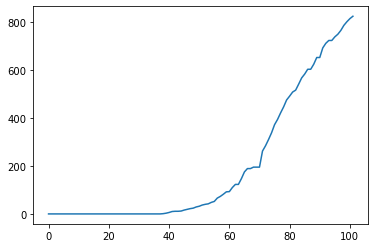

In [5]:
washington.deaths.plot()

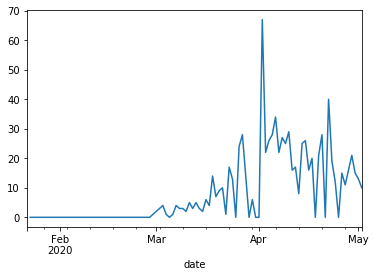

In [8]:
# if you want to look at the cumsum
# although, actually less sure about these...
washington['new_cases'] = washington.cases.diff()
washington['new_deaths'] = washington.deaths.diff()
washington['new_recoverd'] = washington.recovered.diff()
washington['new_tested'] = washington.tested.diff()

washington.set_index('date')['new_deaths'].plot()

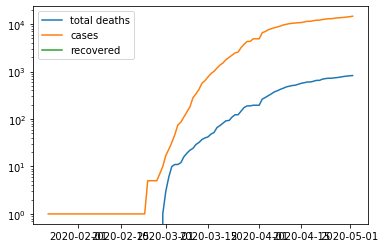

In [9]:
plt.plot(washington.date, washington['deaths'], label='total deaths');
plt.plot(washington.date, washington['cases'], label='cases');
plt.plot(washington.date, washington['recovered'], label='recovered');
plt.yscale('log');
plt.legend();

In [10]:
# mobility = get_data_source('mobility')()
# mobility = pd.read_csv('https://www.gstatic.com/covid19/mobility/Global_Mobility_Report.csv', parse_dates=['date'])
mobility  = get_data_source('mobility')()
mobility.head()

/home/wwymak/anaconda3/envs/immo-ml/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,country_iso,country,region,sub_region,date,retail_recreation,grocery_pharmacy,parks,transit_stations,workplaces,residential
0,AE,United Arab Emirates,NaN,NaN,2020-02-15,0.0,4.0,5.0,0.0,2.0,1.0
1,AE,United Arab Emirates,NaN,NaN,2020-02-16,1.0,4.0,4.0,1.0,2.0,1.0
2,AE,United Arab Emirates,NaN,NaN,2020-02-17,-1.0,1.0,5.0,1.0,2.0,1.0
3,AE,United Arab Emirates,NaN,NaN,2020-02-18,-2.0,1.0,5.0,0.0,2.0,1.0
4,AE,United Arab Emirates,NaN,NaN,2020-02-19,-2.0,0.0,4.0,-1.0,2.0,1.0


In [11]:
 # google's mobility data is further subdivided down to the county level. For the state level, fitler for sub_region_2 is nan
mobility[(mobility.country_iso=='US') & (mobility.region=='Washington')].sub_region.unique()

array([nan, 'Adams County', 'Asotin County', 'Benton County',
       'Chelan County', 'Clallam County', 'Clark County',
       'Cowlitz County', 'Douglas County', 'Ferry County',
       'Franklin County', 'Grant County', 'Grays Harbor County',
       'Island County', 'Jefferson County', 'King County',
       'Kitsap County', 'Kittitas County', 'Klickitat County',
       'Lewis County', 'Lincoln County', 'Mason County',
       'Okanogan County', 'Pacific County', 'Pend Oreille County',
       'Pierce County', 'San Juan County', 'Skagit County',
       'Skamania County', 'Snohomish County', 'Spokane County',
       'Stevens County', 'Thurston County', 'Walla Walla County',
       'Whatcom County', 'Whitman County', 'Yakima County'], dtype=object)

In [12]:
washington_mobility = mobility[(mobility.country_iso=='US') & (mobility.region=='Washington') & mobility.sub_region.isna()].copy()
washington_mobility = washington_mobility.rename(columns={ k: f"mobility_{k}" for k in 
   [ "retail_and_recreation_percent_change_from_baseline", "grocery_and_pharmacy_percent_change_from_baseline", "parks_percent_change_from_baseline", 
    "transit_stations_percent_change_from_baseline",	"workplaces_percent_change_from_baseline", "residential_percent_change_from_baseline"]
})
washington_mobility.shape, washington_mobility.date.unique().shape

((72, 11), (72,))

In [58]:
washington_mobility

,country_region_code,country_region,sub_region_1,sub_region_2,date,mobility_retail_and_recreation_percent_change_from_baseline,mobility_grocery_and_pharmacy_percent_change_from_baseline,mobility_parks_percent_change_from_baseline,mobility_transit_stations_percent_change_from_baseline,mobility_workplaces_percent_change_from_baseline,mobility_residential_percent_change_from_baseline
269706,US,United States,Washington,NaN,2020-02-15,2.0,-1.0,8.0,8.0,-3.0,0.0
269707,US,United States,Washington,NaN,2020-02-16,15.0,3.0,19.0,5.0,-1.0,-1.0
269708,US,United States,Washington,NaN,2020-02-17,12.0,2.0,63.0,-7.0,-35.0,6.0
269709,US,United States,Washington,NaN,2020-02-18,5.0,2.0,52.0,7.0,-4.0,0.0
269710,US,United States,Washington,NaN,2020-02-19,4.0,3.0,60.0,7.0,-2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...
269773,US,United States,Washington,NaN,2020-04-22,-40.0,-14.0,-23.0,-57.0,-55.0,22.0
269774,US,United States,Washington,NaN,2020-04-23,-39.0,-12.0,2.0,-56.0,-54.0,21.0
269775,US,United States,Washington,NaN,2020-04-24,-40.0,-14.0,17.0,-54.0,-53.0,21.0
269776,US,United States,Washington,NaN,2020-04-25,-45.0,-15.0,8.0,-46.0,-37.0,13.0


In [13]:
washington_merged = washington.set_index('date').merge(washington_mobility.set_index('date'), left_index=True, right_index=True, how='inner')

In [14]:
washington_merged

,country_x,region_x,sub_region_x,city,lat,long,url,aggregate,tz,cases,...,country_iso,country_y,region_y,sub_region_y,retail_recreation,grocery_pharmacy,parks,transit_stations,workplaces,residential
date,,,,,,,,,,,,,,,,,,,,,
2020-02-15,United States,Washington,NaN,NaN,47.273,-120.8245,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,...,US,United States,Washington,NaN,2.0,-1.0,8.0,8.0,-3.0,0.0
2020-02-16,United States,Washington,NaN,NaN,47.273,-120.8245,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,...,US,United States,Washington,NaN,15.0,3.0,19.0,5.0,-1.0,-1.0
2020-02-17,United States,Washington,NaN,NaN,47.273,-120.8245,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,...,US,United States,Washington,NaN,12.0,2.0,63.0,-7.0,-35.0,6.0
2020-02-18,United States,Washington,NaN,NaN,47.273,-120.8245,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,...,US,United States,Washington,NaN,5.0,2.0,52.0,7.0,-4.0,0.0
2020-02-19,United States,Washington,NaN,NaN,47.273,-120.8245,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,1,...,US,United States,Washington,NaN,4.0,3.0,60.0,7.0,-2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-22,United States,Washington,NaN,NaN,47.273,-120.8245,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,12494,...,US,United States,Washington,NaN,-40.0,-14.0,-23.0,-57.0,-55.0,22.0
2020-04-23,United States,Washington,NaN,NaN,47.273,-120.8245,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,12753,...,US,United States,Washington,NaN,-39.0,-12.0,2.0,-56.0,-54.0,21.0
2020-04-24,United States,Washington,NaN,NaN,47.273,-120.8245,https://covidtracking.com/api/v1/states/curren...,state,America/Los_Angeles,12977,...,US,United States,Washington,NaN,-40.0,-14.0,17.0,-54.0,-53.0,21.0


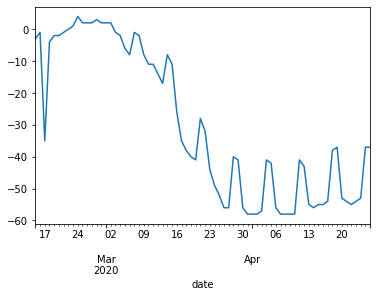

In [65]:
washington_merged.mobility_workplaces_percent_change_from_baseline.plot()